<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-statement" data-toc-modified-id="Problem-statement-1"> <span class="toc-item-num">1&nbsp;&nbsp;</span>Problem statement</a></span></li><li><span><a href="#Download, review -and-resampling-data-one-hour-at-a-time" data-toc-modified-id="Loading,-reviewing-and-resampling-data-one-hour-at-a-time"><span class="toc-item" -num">2&nbsp;&nbsp;</span>Loading, reviewing and resampling data one hour at a time</a></span></li><li><span> <a href="#Data analysis,- preprocessing" data-toc-modified-id="Data analysis, preprocessing-3" > <span class="toc-item-num">3&nbsp;&nbsp;</span>Data analysis, preprocessing </a></span></li><li><span><a href="#Training-several-different-models,-selecting-the-best-hyperparameters-on-the-training-sample" data-toc-modified-id="Training -several-different-models, -selection-of-the-best-hyperparameters-on-the-training-sample-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training of several different models, selection of the best hyperparameters on the training sample</a></span><ul class="toc-item"><li><span><a href="#Preparation-of-features-and-creation-of-samples" data-toc-modified- id="Preparation-of-features-and-creation-of-samples-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Preparation of features and creation of samples</a></span> </li><li><span><a href="#Linear-regression-model" data-toc-modified-id="Linear-regression-model-4.2"><span class="toc-item-num ">4.2&nbsp;&nbsp;</span>Linear Regression Model</a></span></li><li><span><a href="#Random-Forest Model" data-toc-modified- id="Model-Random-Forest-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Model Random Forest</a></span></li><li ><span><a href="#Model-CatBoost" data-toc-modified-id="Model-CatBoost-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span >Model CatBoost</a></span></li><li><span><a href="#Model-LightGBM" data-toc-modified-id="Model-LightGBM-4.5"><span class ="toc-item-num">4.5&nbsp;&nbsp;</span>LightGBM model</a></span></li></ul></li><li><span><a href= "#Checking-the-best-model-on-test-sample" data-toc-modified-id="Checking-the-best-model-on-test-sample-5"><span class="toc-item-num"> 5&nbsp;&nbsp;</span>Testing the best model on a test sample

#  PROJECT

# Development of a machine learning model for predicting taxi orders for the next hour

##  Formulation of the problem

The customer, the Chetenkoe Taxi company, in order to attract more drivers during peak hours, needs to develop a machine learning model to predict the number of orders in the next hour.

To train the model, historical data on the number of taxi orders at airports is available.

Customer requirement for model quality:

- assessment based on the RMSE metric;
- the metric value should not be more than 48 on the test sample.

Thus, it is necessary to solve the problem of regression, supervised learning.


The project will be completed in 4 steps:

1. loading, reviewing and resampling data for one hour;
2. data analysis, preprocessing;
3. training several different models, selecting the best hyperparameters on the training set. (test sample - 10% of the original data);
4. checking the best model on a test sample.

## Loading, reviewing and resampling data one hour at a time

In [ ]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data does not contain gaps, information on orders is presented for the period from March 1 to August 31, 2018

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


The data is presented in 10-minute increments; we will resample the data in 1-hour increments:

In [ ]:
data = data.resample('1H').sum()

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
data.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


**Conclusion by section:**

Data on the number of orders is presented in the proper type, does not contain gaps and, after resampling at 1 hour, does not require further preprocessing.

## Data analysis, preprocessing

In [ ]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


After resampling, the number of data lines was expectedly reduced by 6 times: from 26,496 lines to 4,416 lines.
Noteworthy is the minimum number of orders equal to 0, given that this is data on the number of orders per hour, it is possible that the service has not yet received the necessary popularity among users.

Let's decompose the data, highlighting trend, seasonality and noise. Let's calculate the smoothed trend for the week.

In [ ]:
decomposed = seasonal_decompose(data)

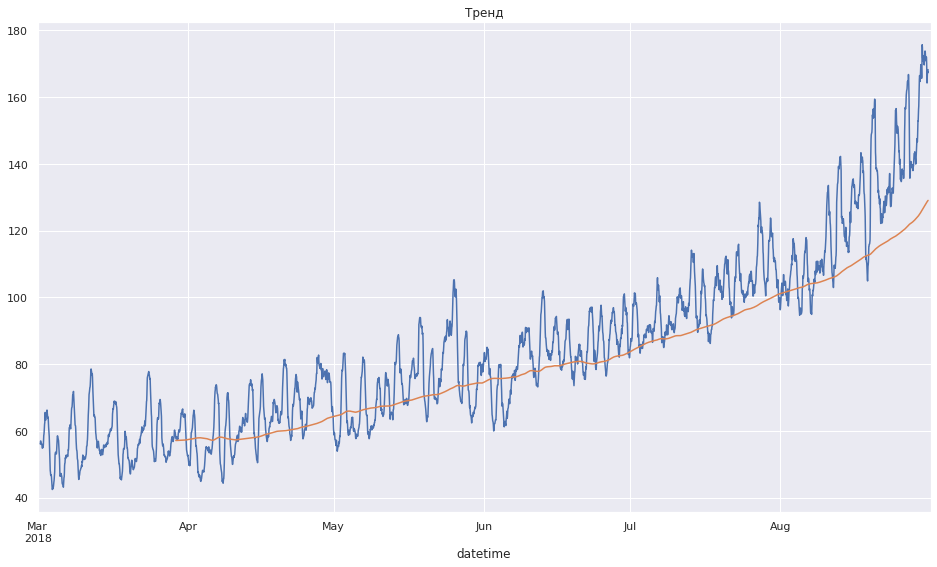

In [ ]:
sns.set(rc={'figure.figsize':(16,9)})

decomposed.trend.plot()
decomposed.trend.rolling(24*7*4).mean().plot()
plt.title('Тренд')
plt.show()

The number of orders is gradually and steadily growing. Moreover. that growth accelerated by August.

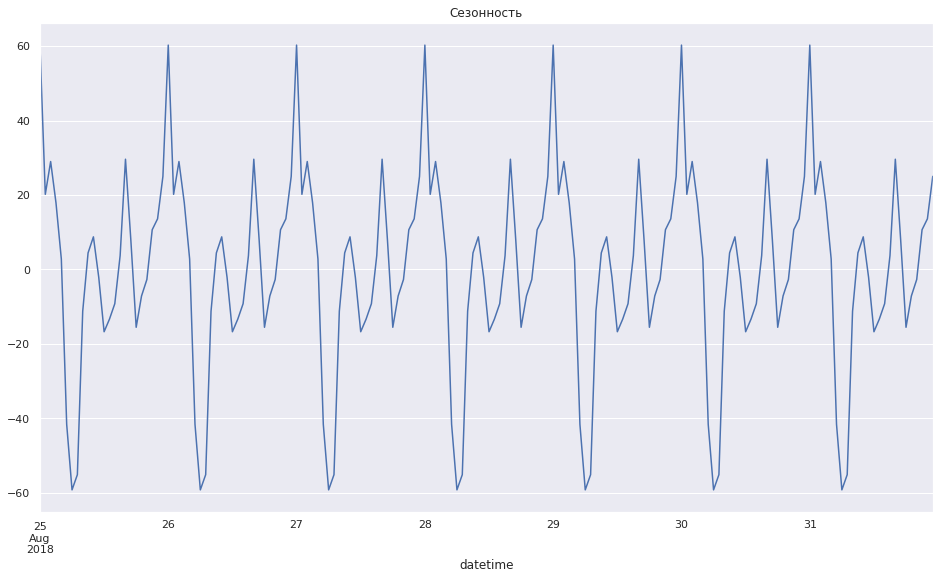

In [ ]:
decomposed.seasonal.tail(24*7).plot()
plt.title('Сезонность')
plt.show()

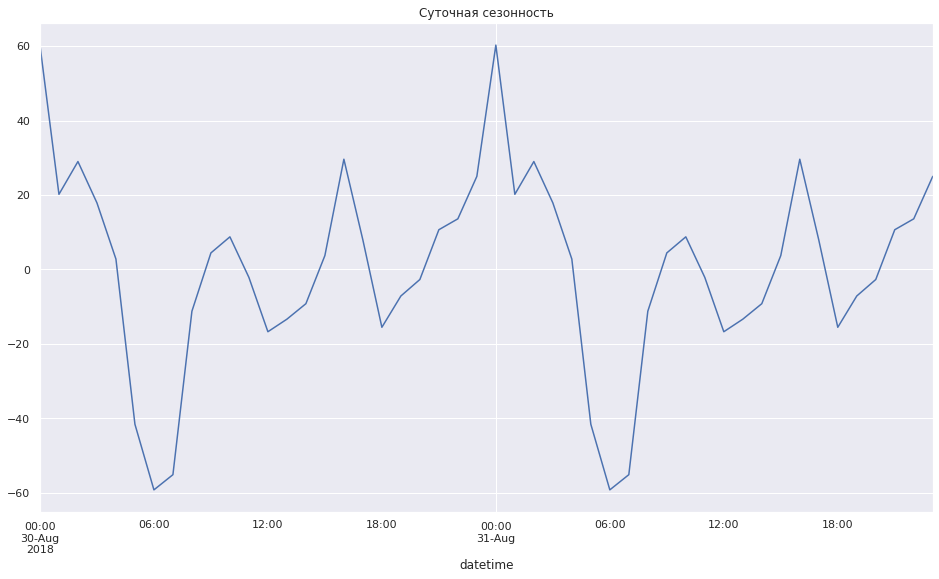

In [ ]:
decomposed.seasonal.tail(24*2).plot()
plt.title('Суточная сезонность')
plt.show()

Daily seasonality is obvious: in the evening the number of orders increases, and during the night there is a drop, as indicated above - down to 0 orders per hour.

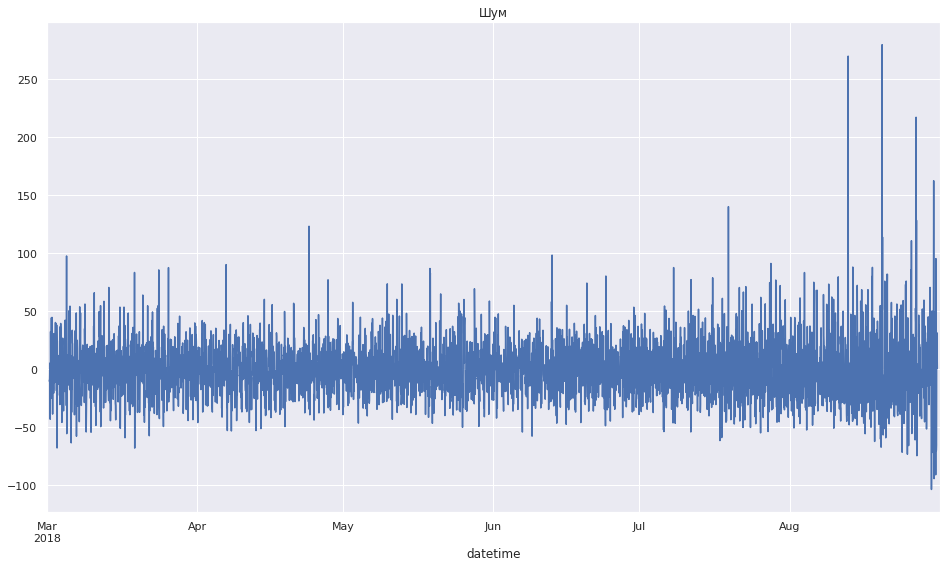

In [ ]:
decomposed.resid.plot()
plt.title('Шум')
plt.show()

Noise in the data is generally uniform with a slight increase since the second half of August. Probably associated with a greater increase in the number of orders during this period.

**Conclusion by section:**

The data does not contain any significant outliers/anomalies and does not require additional processing to form samples of machine learning models.

## Training several different models, selecting the best hyperparameters on the training set

### Preparing features and creating samples

In [ ]:
def make_features (data):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, 4):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(1).mean()
    data.dropna(inplace=True)

    return data

In [ ]:
df_features = data.copy()
df_features = make_features(df_features)

In [ ]:
df_features.shape

(4413, 9)

In [ ]:
target   = df_features['num_orders']
features = df_features.drop(['num_orders'], axis=1)

In [ ]:
features_train, features_test, target_train, target_test = \
                               tts(features, target, shuffle=False, test_size=0.1, random_state=12345)

In [ ]:
features_train.shape

(3971, 8)

In [ ]:
features_test.shape

(442, 8)

The size of the test sample corresponds to the task - 10% of the volume of the original data.

### Linear Regression Model

In [ ]:
model_lr = LinearRegression()

In [ ]:
model_lr.fit(features_train, target_train)
pred = model_lr.predict(features_train)
rmse = mse(target_train, pred, squared=False)

In [ ]:
print('RMSE модели Линейная регрессия:', round(rmse,4))

RMSE модели Линейная регрессия: 30.5624


### Random Forest model

In [ ]:
model_rfr = RandomForestRegressor(random_state=12345)

In [ ]:
grid_search = GridSearchCV(estimator=model_rfr, cv=TimeSeriesSplit(n_splits=5),
                       param_grid={'n_estimators':range(50,551,50), 'max_depth':range(5,26,5)})


In [ ]:
grid_search.fit(features_train, target_train)
grid_search.best_params_

{'max_depth': 20, 'n_estimators': 500}

In [ ]:
pred = grid_search.predict(features_train)
rmse = mse(target_train, pred, squared=False)

In [ ]:
print('RMSE модели Случайный лес:', round(rmse,4))

RMSE модели Случайный лес: 8.2696


### Model CatBoost

In [ ]:
model_cb = CatBoostRegressor(verbose=False)

In [ ]:
model_cb.fit(features_train, target_train, verbose=False)
pred = model_cb.predict(features_train)
rmse = mse(target_train, pred, squared=False)

In [ ]:
print('RMSE модели CatBoost:', round(rmse,4))

RMSE модели CatBoost: 13.8636


### Model LightGBM

In [ ]:
model_lgbm = lgb.LGBMRegressor()

In [ ]:
model_lgbm.fit(features_train, target_train, verbose=False)
pred = model_lgbm.predict(features_train)
rmse = mse(target_train, pred, squared=False)

In [ ]:
print('RMSE модели LightGBM:', round(rmse,4))

RMSE модели LightGBM: 15.5308


**Conclusion by section:**

The best results in terms of the RMSE metric on the training set were shown by the **Random Forest** model. RMSE = 8.269.
In the next section, we will check this model on a test sample to confirm compliance with the Customer’s requirement.

## Checking the best model on a test set

Let's check the best model on the test sample - the Random Forest model.

In [ ]:
pred = grid_search.predict(features_test)
rmse = mse(target_test, pred, squared=False)

In [ ]:
print('RMSE модели Случайный лес на ТЕCТОВОЙ выборке:', round(rmse,4))

RMSE модели Случайный лес на ТЕCТОВОЙ выборке: 47.7137


The customer's requirement for the quality of the model (RMSE value on the test sample is no more than 48) has been met. The model can be considered developed.

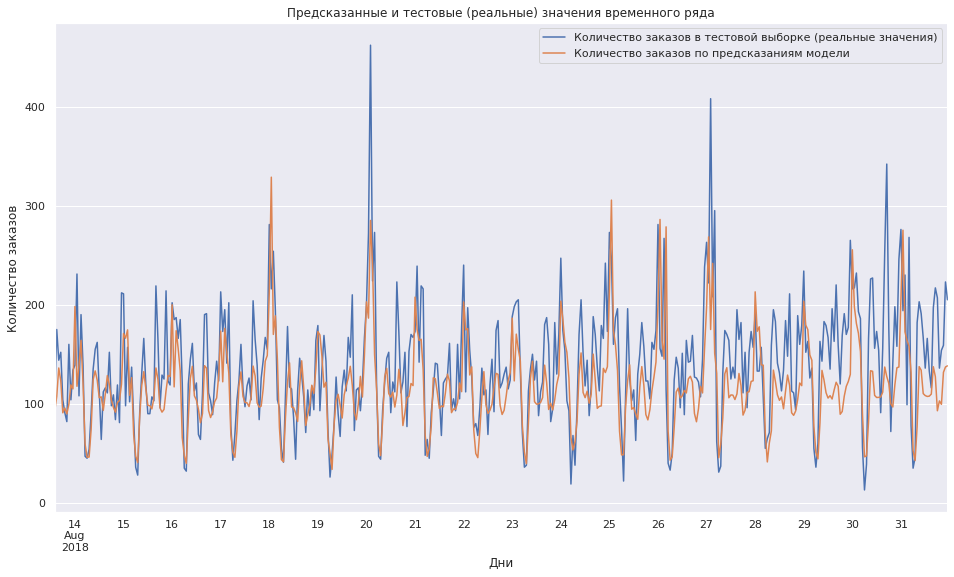

In [ ]:
total_time_line = target_test.to_frame().reset_index()
total_time_line['pred'] = pd.Series(pred)
total_time_line.set_index('datetime', inplace=True)

total_time_line.plot()
plt.title('Предсказанные и тестовые (реальные) значения временного ряда')
plt.xlabel("Дни")
plt.ylabel("Количество заказов")
plt.legend({'Количество заказов в тестовой выборке (реальные значения)','Количество заказов по предсказаниям модели'})
plt.show()

**Conclusion by section:**

On the test sample, the best model defined in the previous section (Random Forest) confirmed its quality. The RMSE metric value corresponds to the customer's requirement (no more than 48). RMSE = 47.71.

**CONCLUSION on the PROJECT:**

The customer, the taxi ordering service "Chetenkoe Taxi", needed to be able to predict the number of taxi orders in the next hour.
To solve this problem, it was necessary to develop a machine learning model (regression problem, supervised learning) that would predict the number of orders based on historical data.
Historical data contained information on the number of orders in the period from March 1 to August 31, 2018.
The total data volume was 26,496 rows.

As a result of working on the project, the data was analyzed and it was determined that the data did not require additional preprocessing. The data was resampled at 1 hour, because The customer needs a forecast of the number of orders for the next hour.

Additional features and samples were generated for training machine learning models.

Trained **4 models**:

- Linear regression,
- Random forest,
- CatBoost
- LightGBM.


The best value of the RMSE metric on the training set was shown by the Random Forest model. RMSE = 8.269.

The **Random Forest** model, with the best hyperparameters (number of trees 500, maximum tree depth 20) was tested on a test sample. The RMSE metric value was 47.71, which meets the customer’s requirement - no more than 48.

Thus, the task set by the customer was fully completed.